In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
import pickle

In [2]:
pbp = pd.read_csv('pbp_pre_shot.csv')
pbp.head()

,id,game_id,season,date,period,poss_num,poss_id,team_id,opp_id,seconds_remaining_game_clock,...,possession_score_differential,seconds_elapsed,coordinate_x,coordinate_y,foul_stage,garbage_time_indicator,last_free_throw,free_throw_source,previous_event_type,previous_possession_end
0,4.004968e+11,400496834,2014,2013-11-08,1,1,120.0,120.0,41,1200,...,0.0,0.0,25.0,0.0,0,0,NaN,NaN,NaN,Other
1,4.004968e+11,400496834,2014,2013-11-08,1,1,120.0,120.0,41,1184,...,0.0,16.0,20.0,4.0,0,0,NaN,NaN,Jump,Other
2,4.004968e+11,400496834,2014,2013-11-08,1,2,41.0,41.0,120,1184,...,0.0,0.0,25.0,0.0,0,0,NaN,NaN,Missed Shot,DREB
3,4.004968e+11,400496834,2014,2013-11-08,1,2,41.0,41.0,120,1169,...,0.0,15.0,31.0,5.0,0,0,NaN,NaN,DREB,DREB
4,4.004968e+11,400496834,2014,2013-11-08,1,2,41.0,41.0,120,1169,...,0.0,0.0,25.0,0.0,0,0,NaN,NaN,Missed Shot,DREB


In [4]:
df_3 = pbp[
    (pbp['event_type'].isin(['Made Shot', 'Missed Shot'])) 
    & (pbp['season'] != 2021) 
    & (pbp['garbage_time_indicator'] == 0)
    & (pbp['foul_stage'] == 0)
    & (pbp['shot_type'] == 'Three')
]

In [5]:
df_3[['coordinate_x', 'coordinate_y']].describe()

,coordinate_x,coordinate_y
count,297575.000000,2.975750e+05
mean,24.353266,-1.428443e+03
std,16.452271,5.567317e+05
min,0.000000,-2.147484e+08
25%,8.000000,8.000000e+00
50%,24.000000,1.700000e+01
75%,41.000000,2.200000e+01
max,50.000000,8.900000e+01


<AxesSubplot:ylabel='Density'>

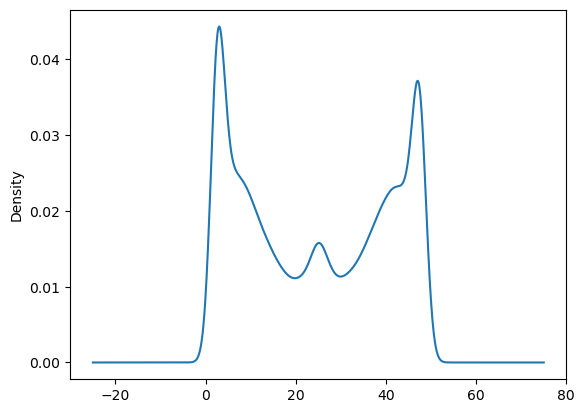

In [6]:
df_3['coordinate_x'].plot.kde()

<AxesSubplot:ylabel='Density'>

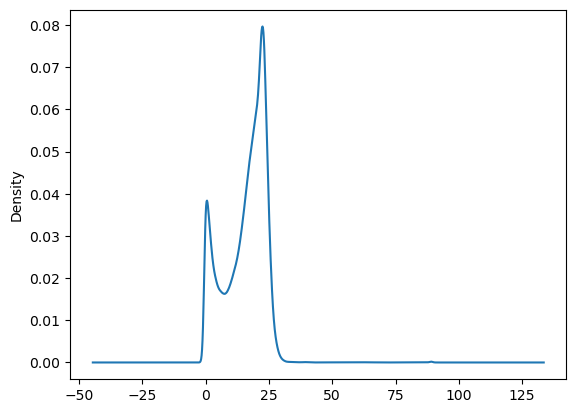

In [7]:
df_3[df_3['coordinate_y'] >= 0]['coordinate_y'].plot.kde()

<AxesSubplot:xlabel='coordinate_y'>

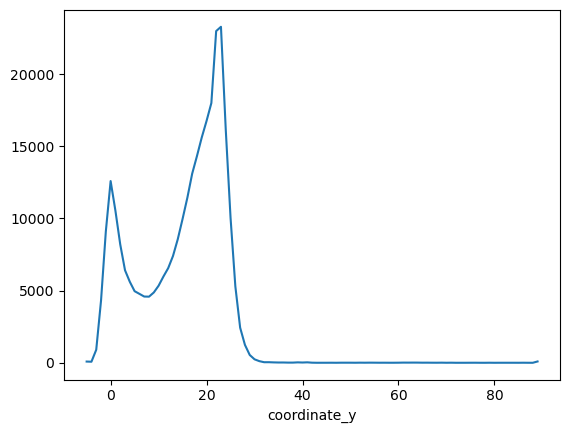

In [8]:
df_3[df_3['coordinate_y'] > -6].groupby('coordinate_y').size().plot()

In [9]:
df_3['distance'] = ((df_3['coordinate_x'] - 25) ** 2 + df_3['coordinate_y'].clip(lower = -1) ** 2) ** 0.5

C:\Users\taylo\AppData\Local\Temp\ipykernel_5320\580705371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['distance'] = ((df_3['coordinate_x'] - 25) ** 2 + df_3['coordinate_y'].clip(lower = -1) ** 2) ** 0.5


In [11]:
def plot_3s(df, dist):
    return df[df['distance'] > dist]['result_points'].mean()

result_df = pd.DataFrame()
for i in range(20, 80):
    avg = plot_3s(df_3, i)
    result_df = pd.concat([result_df, pd.DataFrame({'dist': [i], 'avg': [avg]})])

result_df

,dist,avg
0,20,1.038051
0,21,1.038117
0,22,1.034409
0,23,1.014743
0,24,0.987665
0,25,0.966482
0,26,0.943473
0,27,0.918967
0,28,0.889875
0,29,0.852881


In [12]:
pbp['distance'] = (((pbp['coordinate_x'] - 25) ** 2 + pbp['coordinate_y'].clip(lower = -1) ** 2) ** 0.5).round()
pbp.loc[pbp['distance'] > 36, 'distance'] = np.nan

In [13]:
pbp = pd.merge(pbp, pbp[pbp['shot_type'] == 'Three'].groupby(['shot_type', 'season'])['distance'].agg(pd.Series.mode).reset_index(), how = 'left', on = ['shot_type', 'season'], suffixes = ('' , '_mode'))
pbp['distance'] = pbp['distance'].combine_first(pbp['distance_mode']).clip(lower = 20).fillna(24)

In [14]:
# pre, middle, post shots
# EDA into weighting different percentages
# scale features for 0 to 1
# logistic regression for features

In [15]:
pbp['made'] = np.nan
pbp.loc[pbp['event_type'] == 'Made Shot', 'made'] = 1
pbp.loc[pbp['event_type'] == 'Missed Shot', 'made'] = 0

In [16]:
pbp.loc[pbp['seconds_remaining_game_clock'] < pbp['before_event_seconds_remaining_shot_clock'], 'before_event_seconds_remaining_shot_clock'] = pbp.loc[pbp['seconds_remaining_game_clock'] < pbp['before_event_seconds_remaining_shot_clock'], 'seconds_remaining_game_clock']

In [22]:
df_time = pbp[
    (pbp['event_type'].isin(['Made Shot', 'Missed Shot'])) 
    & (pbp['season'] != 2021) 
    & (pbp['garbage_time_indicator'] == 0)
    & (pbp['foul_stage'] == 0)
    & (pbp['shot_type'].isin(['Three', 'Long Two', 'Layup', 'Dunk']))
]

In [18]:
df_time['before_event_seconds_remaining_shot_clock'].describe()

count    4.602715e+06
mean     2.020922e+01
std      9.849118e+00
min     -1.044000e+03
25%      1.300000e+01
50%      2.000000e+01
75%      3.000000e+01
max      3.500000e+01
Name: before_event_seconds_remaining_shot_clock, dtype: float64

<AxesSubplot:ylabel='Density'>

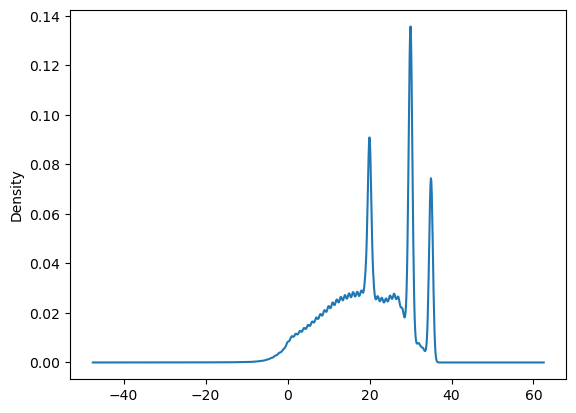

In [19]:
df_time[df_time['before_event_seconds_remaining_shot_clock'] >= -20]['before_event_seconds_remaining_shot_clock'].plot.kde()

In [34]:
plot_df = df_time[df_time['before_event_seconds_remaining_shot_clock'] >= -20].groupby(['shot_type', 'before_event_seconds_remaining_shot_clock'])['made'].mean().reset_index()

<AxesSubplot:xlabel='before_event_seconds_remaining_shot_clock', ylabel='made'>

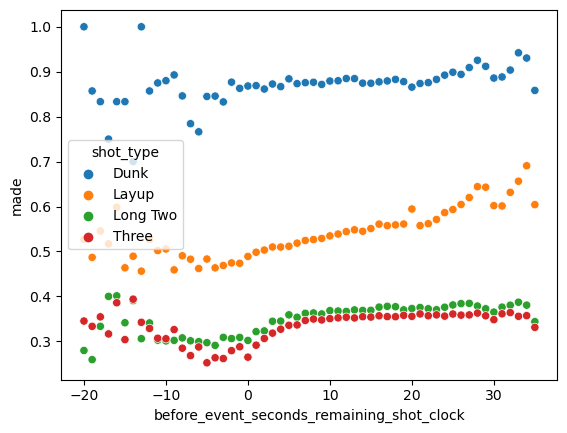

In [31]:
import seaborn as sns
sns.scatterplot(
    x='before_event_seconds_remaining_shot_clock',y='made',hue ='shot_type',
    data=plot_df
) 

<AxesSubplot:xlabel='before_event_seconds_remaining_shot_clock', ylabel='made'>

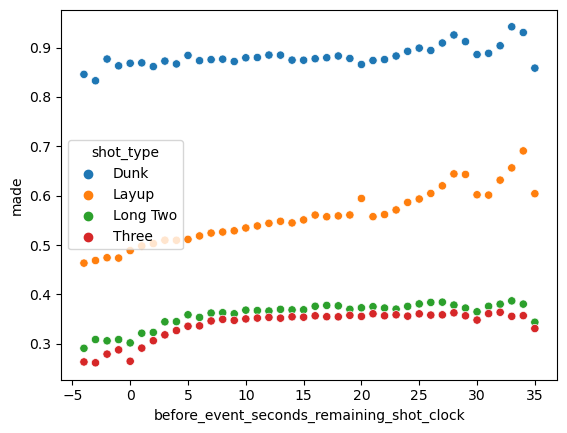

In [32]:
sns.scatterplot(
    x='before_event_seconds_remaining_shot_clock',y='made',hue ='shot_type',
    data=plot_df[plot_df['before_event_seconds_remaining_shot_clock'] > -5]
) 

In [35]:
df_time['previous_possession_end'].unique()

array(['Other', 'DREB', 'TO', 'Made Shot', 'Steal TO', 'Missed Shot',
       'Charge TO'], dtype=object)

C:\Users\taylo\AppData\Local\Temp\ipykernel_5320\3486611626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


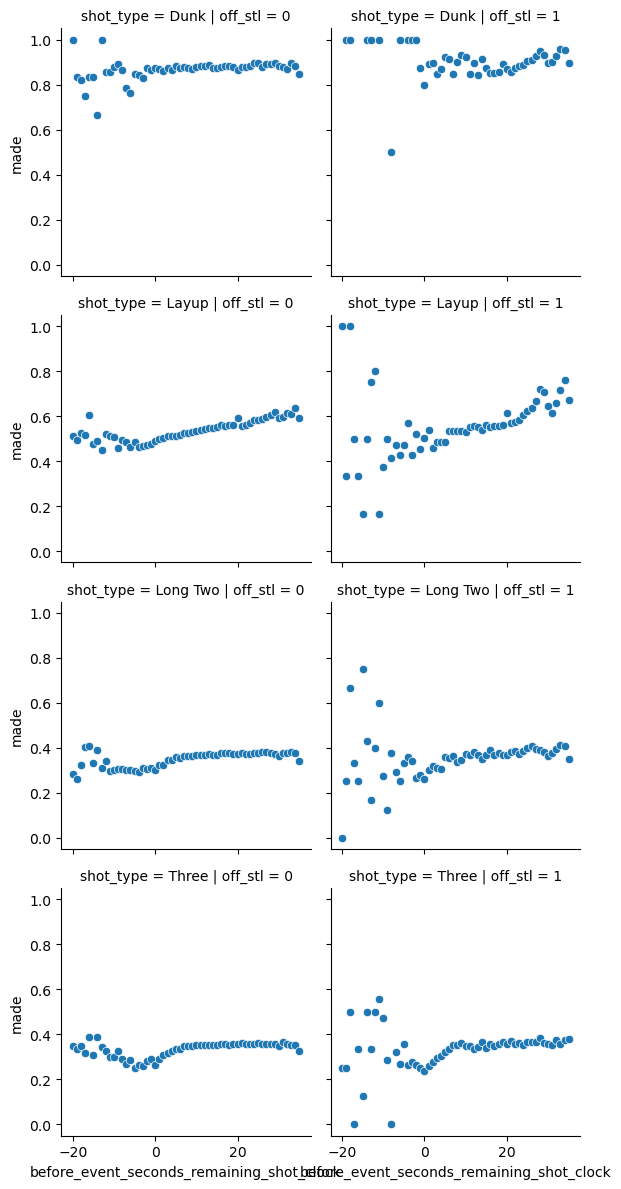

In [36]:
df_time['off_stl'] = 0
df_time.loc[df_time['previous_possession_end'] == 'Steal TO', 'off_stl'] = 1
g = sns.FacetGrid(
    df_time[df_time['before_event_seconds_remaining_shot_clock'] >= -20].groupby(['off_stl', 'shot_type', 'before_event_seconds_remaining_shot_clock'])['made'].mean().reset_index(), 
    row="shot_type", col="off_stl"
)
g.map(sns.scatterplot, "before_event_seconds_remaining_shot_clock", "made")

In [37]:
df_time['shot_clock'] = df_time['season'] > 2015

C:\Users\taylo\AppData\Local\Temp\ipykernel_5320\3056671606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


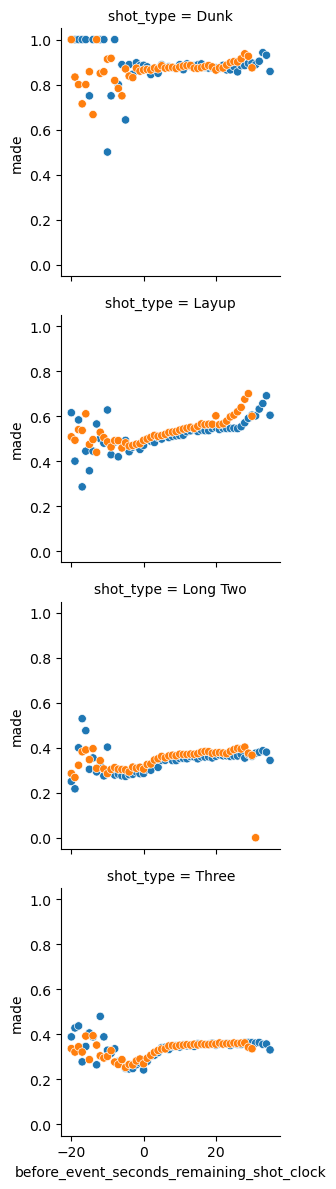

In [40]:
g = sns.FacetGrid(
    df_time[df_time['before_event_seconds_remaining_shot_clock'] >= -20].groupby(['shot_clock', 'shot_type', 'before_event_seconds_remaining_shot_clock'])['made'].mean().reset_index(), 
    row="shot_type"
)
g.map(sns.scatterplot, "before_event_seconds_remaining_shot_clock", "made", 'shot_clock')

In [43]:
df_time['seconds_elapsed_shot_clock'] = 35 - df_time['before_event_seconds_remaining_shot_clock']
df_time.loc[df_time['shot_clock'], 'seconds_elapsed_shot_clock'] = 30 - df_time.loc[df_time['shot_clock'], 'before_event_seconds_remaining_shot_clock']

C:\Users\taylo\AppData\Local\Temp\ipykernel_5320\881441626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


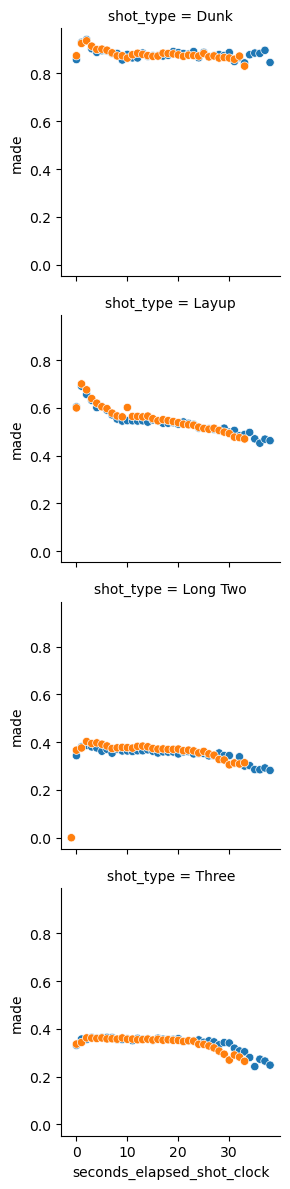

In [46]:
g = sns.FacetGrid(
    df_time[df_time['before_event_seconds_remaining_shot_clock'] >= -3].groupby(['shot_clock', 'shot_type', 'seconds_elapsed_shot_clock'])['made'].mean().reset_index(), 
    row="shot_type"
)
g.map(sns.scatterplot, 'seconds_elapsed_shot_clock', "made", 'shot_clock')

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
import pickle

In [2]:
pbp = pd.read_csv('pbp_pre_shot.csv')
pbp.columns

Index(['id', 'game_id', 'season', 'date', 'period', 'poss_num', 'poss_id',
       'team_id', 'opp_id', 'seconds_remaining_game_clock',
       'before_event_seconds_remaining_shot_clock', 'event_type', 'shot_type',
       'shooting_player_id', 'position', 'result_points',
       'possession_score_differential', 'seconds_elapsed', 'distance',
       'foul_stage', 'garbage_time_indicator', 'last_free_throw',
       'free_throw_source', 'previous_event_type', 'previous_possession_end',
       'home', 'off_stl', 'days_since_season_start', 'shot_blocked',
       'season_adjusted_shot_clock', 'made'],
      dtype='object')

In [3]:
shots = pbp[
    (pbp['shot_type'].isin(['Dunk', 'Layup', 'Free Throw', 'Long Two', 'Three'])) & (pbp['shot_blocked'] == 0)
][['id', 'season', 'date', 'opp_id', 'shot_type', 'shooting_player_id', 'position', 'made', 
   'off_stl', 'distance', 'season_adjusted_shot_clock', 'days_since_season_start', 'home']]
del pbp

In [4]:
shots_new = pd.DataFrame()

for season in [2016, 2017, 2018, 2019, 2020, 2022]:
    shots_pre = shots.copy()
    shots_pre['snapshot_date'] = str(season - 1) + '-11-01'
    shots_pre['snapshot_season'] = season
    shots_mid = shots.copy()
    shots_mid['snapshot_date'] = str(season) + '-01-15'
    shots_mid['snapshot_season'] = season
    shots_end = shots.copy()
    shots_end['snapshot_date'] = str(season) + '-04-15'
    shots_end['snapshot_season'] = season
    shots_new = pd.concat([
        shots_new, 
        shots_pre[(shots_pre['date'] < shots_pre['snapshot_date'])], 
        shots_mid[(shots_mid['date'] < shots_mid['snapshot_date'])], 
        shots_end[(shots_end['date'] < shots_end['snapshot_date'])]
    ])

shots = shots_new.copy()

del shots_pre
del shots_mid
del shots_end
del shots_new

In [5]:
season_stats = shots[
    (shots['season'] == shots['snapshot_season'])
].groupby(
    ['shooting_player_id', 'shot_type', 'snapshot_date', 'season']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()

career_stats = shots.groupby(
    ['shooting_player_id', 'shot_type', 'snapshot_date']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()

opp_stats = shots[
    (shots['season'] == shots['snapshot_season'])
].groupby(
    ['opp_id', 'season', 'snapshot_date', 'shot_type']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()

pos_stats = shots.groupby(
    ['position', 'snapshot_date', 'shot_type']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()


season_stats = pd.DataFrame(
    season_stats.pivot_table(
        index = ['shooting_player_id', 'snapshot_date', 'season'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

career_stats = pd.DataFrame(
    career_stats.pivot_table(
        index = ['shooting_player_id', 'snapshot_date'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

opp_stats = pd.DataFrame(
    opp_stats.pivot_table(
        index = ['opp_id', 'season', 'snapshot_date'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

pos_stats = pd.DataFrame(
    pos_stats.pivot_table(
        index = ['position', 'snapshot_date'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

rename_map = {}
for col in season_stats.columns:
    if ', ' in col:
        col_list = col.replace('(', '').replace(')', '').replace('\'', '').split(', ')
        rename_map[col] = col_list[1].lower() + '_' + col_list[0]

career_stats = career_stats.rename(columns = rename_map)
season_stats = season_stats.rename(columns = rename_map)
opp_stats = opp_stats.rename(columns = rename_map)
pos_stats = pos_stats.rename(columns = rename_map)
del rename_map

In [6]:
for shot in ['dunk', 'layup', 'free throw', 'long two', 'three']:
    career_stats[shot + '_pct'] = career_stats[shot + '_makes'].fillna(0).div(career_stats[shot + '_attempts'])
    season_stats[shot + '_pct'] = season_stats[shot + '_makes'].fillna(0).div(season_stats[shot + '_attempts'])
    opp_stats[shot + '_pct'] = opp_stats[shot + '_makes'].fillna(0).div(opp_stats[shot + '_attempts'])
    pos_stats[shot + '_pct'] = pos_stats[shot + '_makes'].fillna(0).div(pos_stats[shot + '_attempts'])

In [7]:
quantiles = [i / 100 for i in range(1, 100)]
three_percentiles = career_stats[
    (career_stats['three_attempts'] > 4)
].groupby('snapshot_date')['three_pct'].quantile(quantiles).reset_index()
long_percentiles = career_stats[
    (career_stats['long two_attempts'] > 4)
].groupby('snapshot_date')['long two_pct'].quantile(quantiles).reset_index()
ft_percentiles = career_stats[
    (career_stats['free throw_attempts'] > 4)
].groupby('snapshot_date')['free throw_pct'].quantile(quantiles).reset_index()
percentiles = pd.merge(three_percentiles, long_percentiles, how = 'inner', on = ['snapshot_date', 'level_1'])
percentiles = pd.merge(percentiles, ft_percentiles, how = 'inner', on = ['snapshot_date', 'level_1'])
percentiles['fall_back_sort'] = abs(0.5 - percentiles['level_1'])

In [8]:
career_stats = pd.merge(career_stats, percentiles, how = 'inner', on = 'snapshot_date', suffixes = ('', '_ft_percentile'))

In [9]:
career_stats['free_throw_diff'] = abs(career_stats['free throw_pct'] - career_stats['free throw_pct_ft_percentile'])
career_stats = career_stats.sort_values(['shooting_player_id', 'snapshot_date', 'free_throw_diff', 'fall_back_sort']).groupby(['shooting_player_id', 'snapshot_date']).head(1).drop(columns = ['fall_back_sort'])

In [10]:
career_stats = pd.merge(career_stats, percentiles, how = 'inner', on = 'snapshot_date', suffixes = ('', '_3_percentile'))
del percentiles

In [11]:
career_stats['three_diff'] = abs(career_stats['three_pct'] - career_stats['three_pct_3_percentile'])
career_stats = career_stats.sort_values(['shooting_player_id', 'snapshot_date', 'three_diff', 'fall_back_sort']).groupby(['shooting_player_id', 'snapshot_date']).head(1)

In [12]:
drop_cols = []
attempt_cols = []
for col in season_stats.columns:
    if 'pct' in col:
        drop_cols.append(col)

career_stats = career_stats.drop(columns = drop_cols)
season_stats = season_stats.drop(columns=drop_cols)
opp_stats = opp_stats.drop(columns=drop_cols)
pos_stats = pos_stats.drop(columns=drop_cols + attempt_cols)
del drop_cols

In [13]:
shots = pd.concat([shots[shots['shot_type'] == 'Dunk'], shots[shots['shot_type'] != 'Dunk'].sample(10000000)]).reset_index(drop = True)

In [14]:
shots = pd.merge(shots, career_stats, how = 'left', on = ['shooting_player_id', 'snapshot_date'])
del career_stats
shots = pd.merge(shots, season_stats, how = 'left', on = ['shooting_player_id', 'snapshot_date', 'season'], suffixes = (None, '_season'))
del season_stats
shots = pd.merge(shots, opp_stats, how = 'left', on = ['season', 'opp_id', 'snapshot_date'], suffixes = (None, '_opp'))
del opp_stats
shots = pd.merge(shots, pos_stats, how = 'left', on = ['position', 'snapshot_date'], suffixes = (None, '_pos'))
del pos_stats

In [15]:
# adjust makes and attempts for already knowing outcome
for shot in ['dunk', 'layup', 'free throw', 'long two', 'three']:

    to_adj = (
        (shots['shot_type'].str.lower() == shot) & (shots['date'] < shots['snapshot_date'])
    )
    shots.loc[to_adj, shot + '_attempts'] = shots.loc[to_adj, shot + '_attempts'] - 1
    shots.loc[to_adj & (shots['made'] == 1), shot + '_makes'] = shots.loc[to_adj & (shots['made'] == 1), shot + '_makes'] - 1
    shots.loc[to_adj, shot + '_attempts_season'] = shots.loc[to_adj, shot + '_attempts_season'] - 1
    shots.loc[to_adj & (shots['made'] == 1), shot + '_makes_season'] = shots.loc[to_adj & (shots['made'] == 1), shot + '_makes_season'] - 1
    shots.loc[to_adj, shot + '_attempts_opp'] = shots.loc[to_adj, shot + '_attempts_opp'] - 1
    shots.loc[to_adj & (shots['made'] == 1), shot + '_makes_opp'] = shots.loc[to_adj & (shots['made'] == 1), shot + '_makes_opp'] - 1

del to_adj

In [16]:
for shot in ['dunk', 'layup', 'free throw', 'long two', 'three']:
    shots[shot + '_pct'] = shots[shot + '_makes'].fillna(0).div(shots[shot + '_attempts'])
    shots[shot + '_pct_season'] = shots[shot + '_makes_season'].fillna(0).div(shots[shot + '_attempts_season'])
    shots[shot + '_pct_opp'] = shots[shot + '_makes_opp'].fillna(0).div(shots[shot + '_attempts_opp'])
    shots[shot + '_pct_pos'] = shots[shot + '_makes_pos'].fillna(0).div(shots[shot + '_attempts_pos'])

In [17]:
drop_cols = ['id', 'date', 'opp_id', 'shooting_player_id',
       'position', 'snapshot_date', 'snapshot_season', 
       'level_1',
       'free throw_pct_ft_percentile',
       'free_throw_diff', 'level_1_3_percentile', 'three_pct_3_percentile',
       'long two_pct_3_percentile', 
       'fall_back_sort', 'three_diff']

for col in shots.columns:
    if 'make' in col:
        drop_cols.append(col)

shots = shots.drop(columns=drop_cols)
del drop_cols

In [25]:
def test_weights(df, prior_size, season_multiplier, opp_multiplier, percentile_multiplier):

    df['player_shot_make_prob'] = np.nan
    df['total_size'] = np.nan

    df.loc[df['shot_type'] == 'Dunk', 'total_size'] = \
        prior_size + \
        df.loc[df['shot_type'] == 'Dunk', 'dunk_attempts'].fillna(0) + \
        opp_multiplier * df.loc[df['shot_type'] == 'Dunk', 'dunk_attempts_opp'].fillna(0) + \
        season_multiplier * df.loc[df['shot_type'] == 'Dunk', 'dunk_attempts_season'].fillna(0)
    df.loc[df['shot_type'] == 'Dunk', 'player_shot_make_prob'] = (
            prior_size * df.loc[df['shot_type'] == 'Dunk', 'dunk_pct_pos'].fillna(0.9) + \
            df.loc[df['shot_type'] == 'Dunk', 'dunk_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Dunk', 'dunk_pct'].fillna(0) + \
            opp_multiplier * df.loc[df['shot_type'] == 'Dunk', 'dunk_attempts_opp'].fillna(0) * df.loc[df['shot_type'] == 'Dunk', 'dunk_pct_opp'].fillna(0) + \
            season_multiplier * df.loc[df['shot_type'] == 'Dunk', 'dunk_attempts_season'].fillna(0) * df.loc[df['shot_type'] == 'Dunk', 'dunk_pct_season'].fillna(0)
    ).div(df.loc[df['shot_type'] == 'Dunk', 'total_size'])

    df.loc[df['shot_type'] == 'Layup', 'total_size'] = \
        prior_size + \
        df.loc[df['shot_type'] == 'Layup', 'layup_attempts'].fillna(0) + \
        opp_multiplier * df.loc[df['shot_type'] == 'Layup', 'layup_attempts_opp'].fillna(0) + \
        season_multiplier * df.loc[df['shot_type'] == 'Layup', 'layup_attempts_season'].fillna(0)
    df.loc[df['shot_type'] == 'Layup', 'player_shot_make_prob'] = (
            prior_size * df.loc[df['shot_type'] == 'Layup', 'layup_pct_pos'].fillna(0.6) + \
            df.loc[df['shot_type'] == 'Layup', 'layup_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Layup', 'layup_pct'].fillna(0) + \
            opp_multiplier * df.loc[df['shot_type'] == 'Layup', 'layup_attempts_opp'].fillna(0) * df.loc[df['shot_type'] == 'Layup', 'layup_pct_opp'].fillna(0) + \
            season_multiplier * df.loc[df['shot_type'] == 'Layup', 'layup_attempts_season'].fillna(0) * df.loc[df['shot_type'] == 'Layup', 'layup_pct_season'].fillna(0)
    ).div(df.loc[df['shot_type'] == 'Layup', 'total_size'])

    df.loc[df['shot_type'] == 'Free Throw', 'total_size'] = \
        prior_size + \
        df.loc[df['shot_type'] == 'Free Throw', 'free throw_attempts'].fillna(0) + \
        percentile_multiplier * df.loc[df['shot_type'] == 'Free Throw', 'three_attempts'].fillna(0) + \
        season_multiplier * df.loc[df['shot_type'] == 'Free Throw', 'free throw_attempts_season'].fillna(0)
    df.loc[df['shot_type'] == 'Free Throw', 'player_shot_make_prob'] = (
            prior_size * df.loc[df['shot_type'] == 'Free Throw', 'free throw_pct_pos'].fillna(0.7) + \
            df.loc[df['shot_type'] == 'Free Throw', 'free throw_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Free Throw', 'free throw_pct'].fillna(0) + \
            percentile_multiplier * df.loc[df['shot_type'] == 'Free Throw', 'three_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Free Throw', 'free throw_pct_3_percentile'].fillna(0) + \
            season_multiplier * df.loc[df['shot_type'] == 'Free Throw', 'free throw_attempts_season'].fillna(0) * df.loc[df['shot_type'] == 'Free Throw', 'free throw_pct_season'].fillna(0)
    ).div(df.loc[df['shot_type'] == 'Free Throw', 'total_size'])

    df.loc[df['shot_type'] == 'Long Two', 'total_size'] = \
        prior_size + \
        df.loc[df['shot_type'] == 'Long Two', 'long two_attempts'].fillna(0) + \
        opp_multiplier * df.loc[df['shot_type'] == 'Long Two', 'long two_attempts_opp'].fillna(0) + \
        percentile_multiplier * df.loc[df['shot_type'] == 'Long Two', 'free throw_attempts'].fillna(0) + \
        season_multiplier * df.loc[df['shot_type'] == 'Long Two', 'long two_attempts_season'].fillna(0)
    df.loc[df['shot_type'] == 'Long Two', 'player_shot_make_prob'] = (
            prior_size * df.loc[df['shot_type'] == 'Long Two', 'long two_pct_pos'].fillna(0.35) + \
            df.loc[df['shot_type'] == 'Long Two', 'long two_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Long Two', 'long two_pct'].fillna(0) + \
            opp_multiplier * df.loc[df['shot_type'] == 'Long Two', 'long two_attempts_opp'].fillna(0) * df.loc[df['shot_type'] == 'Long Two', 'long two_pct_opp'].fillna(0) + \
            percentile_multiplier * df.loc[df['shot_type'] == 'Long Two', 'free throw_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Long Two', 'long two_pct_ft_percentile'].fillna(0) + \
            season_multiplier * df.loc[df['shot_type'] == 'Long Two', 'long two_attempts_season'].fillna(0) * df.loc[df['shot_type'] == 'Long Two', 'long two_pct_season'].fillna(0)
    ).div(df.loc[df['shot_type'] == 'Long Two', 'total_size'])

    df.loc[df['shot_type'] == 'Three', 'total_size'] = \
        prior_size + \
        df.loc[df['shot_type'] == 'Three', 'three_attempts'].fillna(0) + \
        opp_multiplier * df.loc[df['shot_type'] == 'Three', 'three_attempts_opp'].fillna(0) + \
        percentile_multiplier * df.loc[df['shot_type'] == 'Three', 'free throw_attempts'].fillna(0) + \
        season_multiplier * df.loc[df['shot_type'] == 'Three', 'three_attempts_season'].fillna(0)
    df.loc[df['shot_type'] == 'Three', 'player_shot_make_prob'] = (
            prior_size * df.loc[df['shot_type'] == 'Three', 'three_pct_pos'].fillna(0.3) + \
            df.loc[df['shot_type'] == 'Three', 'three_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Three', 'three_pct'].fillna(0) + \
            opp_multiplier * df.loc[df['shot_type'] == 'Three', 'three_attempts_opp'].fillna(0) * df.loc[df['shot_type'] == 'Three', 'three_pct_opp'].fillna(0) + \
            percentile_multiplier * df.loc[df['shot_type'] == 'Three', 'free throw_attempts'].fillna(0) * df.loc[df['shot_type'] == 'Three', 'three_pct_ft_percentile'].fillna(0) + \
            season_multiplier * df.loc[df['shot_type'] == 'Three', 'three_attempts_season'].fillna(0) * df.loc[df['shot_type'] == 'Three', 'three_pct_season'].fillna(0)
    ).div(df.loc[df['shot_type'] == 'Three', 'total_size'])

    df['log_loss'] = df['made'].mul(np.log(df['player_shot_make_prob'])) + (1 - df['made']).mul(np.log(1 - df['player_shot_make_prob']))
    df['brier_score'] = (df['made'] - df['player_shot_make_prob']) ** 2
    df['bias'] = df['made'] - df['player_shot_make_prob']

    result_df = df.groupby('shot_type')[['log_loss', 'brier_score', 'bias']].mean().reset_index()

    result_df['prior_size'] = prior_size
    result_df['season_multiplier'] = season_multiplier
    result_df['opp_multiplier'] = opp_multiplier
    result_df['percentile_multiplier'] = percentile_multiplier

    return result_df

In [22]:
import random

def get_params():

    prior_size = random.randint(20, 500)
    season_multiplier = np.clip(random.randint(5, 20) / 10.0, a_min=0, a_max = 100)
    opp_multiplier = np.clip(random.randint(-5, 5) / 5.0, a_min=0, a_max = 100)
    percentile_multiplier = np.clip(random.randint(-5, 5) / 5.0, a_min=0, a_max = 100)

    return prior_size, season_multiplier, opp_multiplier, percentile_multiplier

In [ ]:
import random

def get_params():

    prior_size = random.randint(20, 500)
    season_multiplier = 1
    opp_multiplier = 0
    percentile_multiplier = 0

    return prior_size, season_multiplier, opp_multiplier, percentile_multiplier

In [37]:
#weights_df = pd.DataFrame()


for i in [25, 50, 75, 100, 125, 150, 175]:

    prior_size, season_multiplier, opp_multiplier, percentile_multiplier = get_params()
    prior_size = i
    weights_df = pd.concat([weights_df, test_weights(shots, prior_size, season_multiplier, opp_multiplier, percentile_multiplier)])

In [47]:
weights_df[(weights_df['shot_type'] == 'Three') & (weights_df['percentile_multiplier'] == 0) & (weights_df['opp_multiplier'] == 0)].sort_values('log_loss', ascending = False).head(20)

,shot_type,log_loss,brier_score,bias,prior_size,season_multiplier,opp_multiplier,percentile_multiplier
4,Three,-0.645418,0.226547,-0.004856,236,0.5,0.0,0.0
4,Three,-0.645427,0.226551,-0.004815,250,1.1,0.0,0.0
4,Three,-0.645428,0.226551,-0.004846,244,1.2,0.0,0.0
4,Three,-0.645430,0.226552,-0.004835,247,1.3,0.0,0.0
4,Three,-0.645437,0.226555,-0.004863,243,1.7,0.0,0.0
4,Three,-0.645437,0.226556,-0.004992,214,1.6,0.0,0.0
4,Three,-0.645437,0.226555,-0.004845,247,1.7,0.0,0.0
4,Three,-0.645437,0.226556,-0.005001,212,1.6,0.0,0.0
4,Three,-0.645437,0.226556,-0.004945,225,1.7,0.0,0.0
4,Three,-0.645444,0.226558,-0.004616,297,1.6,0.0,0.0


Season multiplier of 1, opp and pct multiplier of 0

Dunk: 75
Layup: 75
Free Throw: 25
Long Two: 125
Three: 125

In [18]:
shots['player_shot_make_prob'] = np.nan
shots['total_size'] = np.nan

shots.loc[shots['shot_type'] == 'Dunk', 'total_size'] = \
    75 + \
    shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Dunk', 'player_shot_make_prob'] = (
        75 * shots.loc[shots['shot_type'] == 'Dunk', 'dunk_pct_pos'].fillna(0.9) + \
        shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Dunk', 'dunk_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Dunk', 'dunk_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Dunk', 'total_size'])

shots.loc[shots['shot_type'] == 'Layup', 'total_size'] = \
    75 + \
    shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Layup', 'player_shot_make_prob'] = (
        75 * shots.loc[shots['shot_type'] == 'Layup', 'layup_pct_pos'].fillna(0.6) + \
        shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Layup', 'layup_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Layup', 'layup_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Layup', 'total_size'])

shots.loc[shots['shot_type'] == 'Free Throw', 'total_size'] = \
    25 + \
    shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Free Throw', 'player_shot_make_prob'] = (
        25 * shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_pct_pos'].fillna(0.7) + \
        shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Free Throw', 'total_size'])

shots.loc[shots['shot_type'] == 'Long Two', 'total_size'] = \
    125 + \
    shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Long Two', 'player_shot_make_prob'] = (
        125 * shots.loc[shots['shot_type'] == 'Long Two', 'long two_pct_pos'].fillna(0.35) + \
        shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Long Two', 'long two_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Long Two', 'long two_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Long Two', 'total_size'])

shots.loc[shots['shot_type'] == 'Three', 'total_size'] = \
    125 + \
    shots.loc[shots['shot_type'] == 'Three', 'three_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Three', 'three_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Three', 'player_shot_make_prob'] = (
        125 * shots.loc[shots['shot_type'] == 'Three', 'three_pct_pos'].fillna(0.3) + \
        shots.loc[shots['shot_type'] == 'Three', 'three_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Three', 'three_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Three', 'three_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Three', 'three_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Three', 'total_size'])

In [19]:
shots['off_stl_under10'] = shots['off_stl'].mul((shots['season_adjusted_shot_clock'] > 20).astype(int))

In [20]:
# features to use per shot type
features = {
    'Layup': ['season', 'season_adjusted_shot_clock', 'days_since_season_start', 'off_stl', 'player_shot_make_prob','off_stl_under10'],
    'Dunk': ['season', 'season_adjusted_shot_clock', 'days_since_season_start', 'off_stl', 'player_shot_make_prob','off_stl_under10'],
    'Free Throw': ['season', 'days_since_season_start', 'home', 'player_shot_make_prob'],
    'Long Two': ['season', 'season_adjusted_shot_clock', 'days_since_season_start', 'off_stl', 'home', 'distance', 'player_shot_make_prob','off_stl_under10'],
    'Three': ['season', 'season_adjusted_shot_clock', 'days_since_season_start', 'off_stl', 'home', 'distance', 'player_shot_make_prob','off_stl_under10']
}

In [21]:
shots = shots[['shot_type', 'made'] + list(set(features['Three'] + features['Long Two'] + features['Free Throw'] + features['Layup'] + features['Dunk']))]

In [22]:
shots['log_loss'] = shots['made'].mul(np.log(shots['player_shot_make_prob'])) + (1 - shots['made']).mul(np.log(1 - shots['player_shot_make_prob']))

In [23]:
y = shots['made']
X = shots.drop(columns = ['made', 'log_loss'])

In [24]:
X['season'] = (X['season'] - 2014) / 8
X['season_adjusted_shot_clock'] = X['season_adjusted_shot_clock'] / 30
X['days_since_season_start'] = X['days_since_season_start'] / 150
X.loc[X['shot_type'] == 'Three', 'distance'] = (X.loc[X['shot_type'] == 'Three', 'distance'] - 20) / 16
X.loc[X['shot_type'] == 'Long Two', 'distance'] = (X.loc[X['shot_type'] == 'Long Two', 'distance'] - 0) / 21

In [25]:
import itertools
from tqdm.notebook import tqdm

In [26]:
result_df = pd.DataFrame()

c = [1, 1e1, 1e4, 1e5]

for shot in tqdm(['Dunk', 'Layup', 'Long Two', 'Three']):

    for i in range(len(features[shot]) + 1):
        for fs in itertools.combinations(features[shot], i):

            if 'player_shot_make_prob' in fs and not ('off_stl' in fs and 'off_stl_under10' in fs):

                X_shot = X[X['shot_type'] == shot][list(fs)]
                y_shot = y[X_shot.index] 

                lm = LogisticRegressionCV(
                    cv = 3, 
                    random_state = 0, 
                    Cs = c,
                    n_jobs = -1,
                    scoring = 'neg_log_loss',
                ).fit(X_shot, y_shot)

                result_df = pd.concat([
                    result_df,
                    pd.DataFrame({
                        'shot_type': [shot] * len(c),
                        'num_features': [len(fs)] * len(c),
                        'features': [fs] * len(c),
                        'c': c,
                        'model_coef': [lm.coef_] * len(c),
                        'score': list(np.mean(lm.scores_[1], axis = 0))
                    })
                ])

  0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
shots.groupby('shot_type')['log_loss'].mean()

shot_type
Dunk         -0.296107
Free Throw   -0.593904
Layup        -0.649805
Long Two     -0.665116
Three        -0.645491
Name: log_loss, dtype: float64

In [27]:
result_df = result_df.reset_index()

In [136]:
result_df[result_df['shot_type'] == 'Three'].sort_values('score', ascending = False).groupby('num_features').head(5)

,index,shot_type,num_features,features,c,model_coef,score
2476,6,Three,7,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+06,"[[0.06542185844929453, 0.22998320724109578, 0....",-0.644694
2475,5,Three,7,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+05,"[[0.06542185844929453, 0.22998320724109578, 0....",-0.644694
2472,2,Three,7,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+02,"[[0.06542185844929453, 0.22998320724109578, 0....",-0.644694
2474,4,Three,7,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+04,"[[0.06542185844929453, 0.22998320724109578, 0....",-0.644694
2478,8,Three,7,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+10,"[[0.06542185844929453, 0.22998320724109578, 0....",-0.644694
2370,0,Three,6,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+00,"[[0.06515909166844015, 0.2246467143107773, 0.0...",-0.644695
2371,1,Three,6,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+01,"[[0.06515909166844015, 0.2246467143107773, 0.0...",-0.644695
2372,2,Three,6,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+02,"[[0.06515909166844015, 0.2246467143107773, 0.0...",-0.644695
2373,3,Three,6,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+03,"[[0.06515909166844015, 0.2246467143107773, 0.0...",-0.644695
2374,4,Three,6,"(season, season_adjusted_shot_clock, days_sinc...",1.000000e+04,"[[0.06515909166844015, 0.2246467143107773, 0.0...",-0.644695


In [135]:
result_df.loc[1414, 'features']

('season',
 'season_adjusted_shot_clock',
 'days_since_season_start',
 'home',
 'distance',
 'player_shot_make_prob')

Free Throw: just use player_shot_make_prob

Dunk: off_stl_under10, player_shot_make_prob and C = 1e1

Layup: season_adjusted_shot_clock, off_stl_under10, player_shot_make_prob and C = 1e4

Long Two: player_shot_make_prob, distance, season_adjusted_shot_clock, home and C=1e5

Three: player_shot_make_prob, distance, season_adjusted_shot_clock, home and C = 1e0

In [28]:
result_df[(result_df['shot_type'] == 'Dunk') & (result_df['num_features'] == 2) & (result_df['c'] == 1e1)].sort_values('score').tail(1)

,index,shot_type,num_features,features,c,model_coef,score
21,1,Dunk,2,"(player_shot_make_prob, off_stl_under10)",10.0,"[[13.998049719161015, 0.4218700040361476]]",-0.295191


In [32]:
for i in range(result_df.loc[21, 'num_features']):
    print(result_df.loc[21, 'features'][i] + ': ' + str(result_df.loc[21, 'model_coef'][0][i]))

player_shot_make_prob: 13.998049719161015
off_stl_under10: 0.4218700040361476


In [29]:
result_df[(result_df['shot_type'] == 'Layup') & (result_df['num_features'] == 3) & (result_df['c'] == 1e4)].sort_values('score').tail(1)

,index,shot_type,num_features,features,c,model_coef,score
146,2,Layup,3,"(season_adjusted_shot_clock, player_shot_make_...",10000.0,"[[0.43906692308974465, 4.36846702814322, 0.297...",-0.646527


In [33]:
for i in range(result_df.loc[146, 'num_features']):
    print(result_df.loc[146, 'features'][i] + ': ' + str(result_df.loc[146, 'model_coef'][0][i]))

season_adjusted_shot_clock: 0.43906692308974465
player_shot_make_prob: 4.36846702814322
off_stl_under10: 0.2977738690391916


In [30]:
result_df[(result_df['shot_type'] == 'Long Two') & (result_df['num_features'] == 4) & (result_df['c'] == 1e5)].sort_values('score').tail(1)

,index,shot_type,num_features,features,c,model_coef,score
387,3,Long Two,4,"(season_adjusted_shot_clock, home, distance, p...",100000.0,"[[0.2893099656831078, 0.06951396221098587, -0....",-0.664311


In [34]:
for i in range(result_df.loc[387, 'num_features']):
    print(result_df.loc[387, 'features'][i] + ': ' + str(result_df.loc[387, 'model_coef'][0][i]))

season_adjusted_shot_clock: 0.2893099656831078
home: 0.06951396221098587
distance: -0.2636009275545524
player_shot_make_prob: 3.7006321472027115


In [31]:
result_df[(result_df['shot_type'] == 'Three') & (result_df['num_features'] == 4) & (result_df['c'] == 1e0)].sort_values('score').tail(1)

,index,shot_type,num_features,features,c,model_coef,score
768,0,Three,4,"(season_adjusted_shot_clock, home, distance, p...",1.0,"[[0.21903748890628796, 0.07559621831930932, -0...",-0.644684


In [35]:
for i in range(result_df.loc[768, 'num_features']):
    print(result_df.loc[768, 'features'][i] + ': ' + str(result_df.loc[768, 'model_coef'][0][i]))

season_adjusted_shot_clock: 0.21903748890628796
home: 0.07559621831930932
distance: -0.5344366327868145
player_shot_make_prob: 3.4889649292106006


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
pbp = pd.read_csv('pbp_pre_shot.csv')

In [3]:
shots = pbp[
    (pbp['shot_type'].isin(['Dunk', 'Layup', 'Free Throw', 'Long Two', 'Three'])) & (pbp['shot_blocked'] == 0)
][['id', 'season', 'date', 'opp_id', 'shot_type', 'shooting_player_id', 'position', 'made', 
   'off_stl', 'distance', 'season_adjusted_shot_clock', 'days_since_season_start', 'home']]
del pbp

In [5]:
season_stats = shots.groupby(
    ['shooting_player_id', 'shot_type', 'season']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()

career_stats = shots.groupby(
    ['shooting_player_id', 'shot_type']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()

pos_stats = shots.groupby(
    ['position', 'shot_type']
).agg(
    makes = ('made', sum),
    attempts = ('id', len)
).reset_index()


season_stats = pd.DataFrame(
    season_stats.pivot_table(
        index = ['shooting_player_id', 'season'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

career_stats = pd.DataFrame(
    career_stats.pivot_table(
        index = ['shooting_player_id'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

pos_stats = pd.DataFrame(
    pos_stats.pivot_table(
        index = ['position'], 
        columns = 'shot_type', 
        values = ['makes', 'attempts'], 
        fill_value = 0
    ).to_records()
)

rename_map = {}
for col in season_stats.columns:
    if ', ' in col:
        col_list = col.replace('(', '').replace(')', '').replace('\'', '').split(', ')
        rename_map[col] = col_list[1].lower() + '_' + col_list[0]

career_stats = career_stats.rename(columns = rename_map)
season_stats = season_stats.rename(columns = rename_map)
pos_stats = pos_stats.rename(columns = rename_map)
del rename_map

In [6]:
for shot in ['dunk', 'layup', 'free throw', 'long two', 'three']:
    career_stats[shot + '_pct'] = career_stats[shot + '_makes'].fillna(0).div(career_stats[shot + '_attempts'])
    season_stats[shot + '_pct'] = season_stats[shot + '_makes'].fillna(0).div(season_stats[shot + '_attempts'])
    pos_stats[shot + '_pct'] = pos_stats[shot + '_makes'].fillna(0).div(pos_stats[shot + '_attempts'])

In [7]:
shots = pd.merge(shots, career_stats, how = 'left', on = ['shooting_player_id'])
del career_stats
shots = pd.merge(shots, season_stats, how = 'left', on = ['shooting_player_id', 'season'], suffixes = (None, '_season'))
del season_stats
shots = pd.merge(shots, pos_stats, how = 'left', on = ['position'], suffixes = (None, '_pos'))
del pos_stats

In [8]:
shots['player_shot_make_prob'] = np.nan
shots['total_size'] = np.nan

shots.loc[shots['shot_type'] == 'Dunk', 'total_size'] = \
    75 + \
    shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Dunk', 'player_shot_make_prob'] = (
        75 * shots.loc[shots['shot_type'] == 'Dunk', 'dunk_pct_pos'].fillna(0.9) + \
        shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Dunk', 'dunk_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Dunk', 'dunk_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Dunk', 'dunk_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Dunk', 'total_size'])

shots.loc[shots['shot_type'] == 'Layup', 'total_size'] = \
    75 + \
    shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Layup', 'player_shot_make_prob'] = (
        75 * shots.loc[shots['shot_type'] == 'Layup', 'layup_pct_pos'].fillna(0.6) + \
        shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Layup', 'layup_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Layup', 'layup_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Layup', 'layup_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Layup', 'total_size'])

shots.loc[shots['shot_type'] == 'Free Throw', 'total_size'] = \
    25 + \
    shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Free Throw', 'player_shot_make_prob'] = (
        25 * shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_pct_pos'].fillna(0.7) + \
        shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Free Throw', 'free throw_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Free Throw', 'total_size'])

shots.loc[shots['shot_type'] == 'Long Two', 'total_size'] = \
    125 + \
    shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Long Two', 'player_shot_make_prob'] = (
        125 * shots.loc[shots['shot_type'] == 'Long Two', 'long two_pct_pos'].fillna(0.35) + \
        shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Long Two', 'long two_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Long Two', 'long two_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Long Two', 'long two_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Long Two', 'total_size'])

shots.loc[shots['shot_type'] == 'Three', 'total_size'] = \
    125 + \
    shots.loc[shots['shot_type'] == 'Three', 'three_attempts'].fillna(0) + \
    shots.loc[shots['shot_type'] == 'Three', 'three_attempts_season'].fillna(0)
shots.loc[shots['shot_type'] == 'Three', 'player_shot_make_prob'] = (
        125 * shots.loc[shots['shot_type'] == 'Three', 'three_pct_pos'].fillna(0.3) + \
        shots.loc[shots['shot_type'] == 'Three', 'three_attempts'].fillna(0) * shots.loc[shots['shot_type'] == 'Three', 'three_pct'].fillna(0) + \
        shots.loc[shots['shot_type'] == 'Three', 'three_attempts_season'].fillna(0) * shots.loc[shots['shot_type'] == 'Three', 'three_pct_season'].fillna(0)
).div(shots.loc[shots['shot_type'] == 'Three', 'total_size'])

In [9]:
shots['off_stl_under10'] = shots['off_stl'].mul((shots['season_adjusted_shot_clock'] > 20).astype(int))

In [10]:
# features to use per shot type
features = {
    'Layup': ['season_adjusted_shot_clock', 'off_stl_under10', 'player_shot_make_prob'],
    'Dunk': ['off_stl_under10', 'player_shot_make_prob'],
    'Long Two': ['season_adjusted_shot_clock', 'home', 'distance', 'player_shot_make_prob'],
    'Three': ['season_adjusted_shot_clock', 'home', 'distance', 'player_shot_make_prob']
}

In [12]:
shots = shots[['shot_type', 'made'] + list(set(features['Three'] + features['Long Two'] + features['Layup'] + features['Dunk']))]

In [13]:
shots['season_adjusted_shot_clock'] = shots['season_adjusted_shot_clock'] / 30
shots.loc[shots['shot_type'] == 'Three', 'distance'] = (shots.loc[shots['shot_type'] == 'Three', 'distance'] - 20) / 36
shots.loc[shots['shot_type'] == 'Long Two', 'distance'] = (shots.loc[shots['shot_type'] == 'Long Two', 'distance'] - 0) / 21

In [17]:
lm = LogisticRegression(
    C = 1e1,
    n_jobs = -1
).fit(
    shots[shots['shot_type'] == 'Dunk'][features['Dunk']], 
    shots[shots['shot_type'] == 'Dunk']['made']
)
pickle.dump(lm, open('models/dunk.sav', 'wb'))
for i in range(len(features['Dunk'])):
    print(features['Dunk'][i] + ': ' + str(lm.coef_[0][i]))

off_stl_under10: 0.5857939426351492
player_shot_make_prob: 32.181755124210454


In [18]:
lm = LogisticRegression(
    C = 1e4,
    n_jobs = -1
).fit(
    shots[shots['shot_type'] == 'Layup'][features['Layup']], 
    shots[shots['shot_type'] == 'Layup']['made']
)
pickle.dump(lm, open('models/layup.sav', 'wb'))
for i in range(len(features['Layup'])):
    print(features['Layup'][i] + ': ' + str(lm.coef_[0][i]))

season_adjusted_shot_clock: 0.4561968800344505
off_stl_under10: 0.3327349192101505
player_shot_make_prob: 7.186106008435252


In [19]:
lm = LogisticRegression(
    C = 1e5,
    n_jobs = -1
).fit(
    shots[shots['shot_type'] == 'Long Two'][features['Long Two']], 
    shots[shots['shot_type'] == 'Long Two']['made']
)
pickle.dump(lm, open('models/long_two.sav', 'wb'))
for i in range(len(features['Long Two'])):
    print(features['Long Two'][i] + ': ' + str(lm.coef_[0][i]))

season_adjusted_shot_clock: 0.29583930967764893
home: 0.057894826430668754
distance: -0.25639871289428057
player_shot_make_prob: 8.352110348199947


In [20]:
lm = LogisticRegression(
    C = 1e0,
    n_jobs = -1
).fit(
    shots[shots['shot_type'] == 'Three'][features['Three']], 
    shots[shots['shot_type'] == 'Three']['made']
)
pickle.dump(lm, open('models/three.sav', 'wb'))
for i in range(len(features['Three'])):
    print(features['Three'][i] + ': ' + str(lm.coef_[0][i]))

season_adjusted_shot_clock: 0.18877898994610534
home: 0.07637145404521288
distance: -0.6537433520644257
player_shot_make_prob: 8.063287122378359
